# Primary Reference Fuel (PRF) Autoignition

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 17 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 5 March 2020.

The objective of this tutorial is to provide further insight into the autoignition of primary reference fuels (PRFs), emphasizing the differences in behavior between n-heptane and iso-octane. We will use the thermodynamic properties and the reaction mechanism that are included in CurrenEtAl_PRF_fromLLNL.cti.

The file "CurrenEtAl_PRF_fromLLNL.cti" (provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place.

The reader should be familiar with the material in the Notebooks for previous chapters before working through this Notebook.

## 1. Motivation and background

Primary reference fuels (PRFs) and autoignition were introduced in tutorial Notebooks 5_4_A_larger_reaction_mechanism and 6_1_Ignition delay, respectively. Here we will compare the autoignition behavior of n-heptane (PRF0, often used as a surrogate for diesel fuel) to that of iso-octane (PRF100, often used as a surrogate for gasoline). The same detailed chemical mechanism that was used in 5_4_A_larger_reaction_mechanism will be used here. The computational times required will therefore be long, compared to those for most of the earlier tutorial Notebooks.

## 2. Heat-release rate and ignition delay for a constant-volume adiabatic reactor

We consider autoignition of n-heptane/air and iso-octane/air mixtures in a constant-volume adiabatic reactor, for the same initial conditions considered in tutorial Notebook 6_1_Ignition_delay.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define a gas mixture based on CurranEtAl_PRF_fromLLNL.cti
# the file "CurranEtAl_PRF_fromLLNL.cti" must be present in subdirectory "data" below the current working directory
gas = ct.Solution('data/CurranEtAl_PRF_fromLLNL.cti')



**** WARNING ****
For species TC3H6CHO, discontinuity in h/RT detected at Tmid = 1389
	Value computed using low-temperature polynomial:  12.1489
	Value computed using high-temperature polynomial: 12.1062


**** WARNING ****
For species C7H15O-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


As we have seen before, the warnings pertain to discontinuities in thermodynamic properties at temperature Tmid. Here we will live with the small discontinuities, which will not cause problems for our current purposes.

In [3]:
# print the number of species and the number of reactions in the reaction mechanism
gas.n_species, gas.n_reactions

(1034, 8453)

In [4]:
# print the list of species names
gas.species_names

['H',
 'H2',
 'O',
 'O2',
 'OH',
 'H2O',
 'N2',
 'CO',
 'HCO',
 'CO2',
 'CH3',
 'CH4',
 'HO2',
 'H2O2',
 'CH2O',
 'CH3O',
 'C2H6',
 'C2H4',
 'C2H5',
 'CH2',
 'CH',
 'C2H',
 'C2H2',
 'C2H3',
 'CH3OH',
 'CH2OH',
 'CH2CO',
 'HCCO',
 'C2H5OH',
 'PC2H4OH',
 'SC2H4OH',
 'CH3CO',
 'CH2CHO',
 'CH3CHO',
 'C3H4-A',
 'C3H4-P',
 'C3H6',
 'C4H6',
 'NC3H7',
 'IC3H7',
 'C3H8',
 'IC4H7',
 'IC4H8',
 'C4H7',
 'C4H8-2',
 'C4H8-1',
 'SC4H9',
 'PC4H9',
 'TC4H9',
 'IC4H9',
 'IC4H10',
 'C4H10',
 'CH3COCH3',
 'CH3COCH2',
 'C2H5CHO',
 'C2H5CO',
 'C5H9',
 'C5H10-1',
 'C5H10-2',
 'IC5H12',
 'AC5H11',
 'BC5H11',
 'CC5H11',
 'DC5H11',
 'AC5H10',
 'BC5H10',
 'CC5H10',
 'IC5H9',
 'NC5H12',
 'C5H11-1',
 'C5H11-2',
 'C5H11-3',
 'NEOC5H12',
 'NEOC5H11',
 'C2H5O',
 'CH3O2',
 'C2H5O2',
 'CH3O2H',
 'C2H5O2H',
 'C2H3O1-2',
 'CH3CO2',
 'C2H4O1-2',
 'C2H4O2H',
 'O2C2H4OH',
 'CH3CO3',
 'CH3CO3H',
 'C2H3CO',
 'C2H3CHO',
 'C3H5O',
 'C3H6OOH1-2',
 'C3H6OOH1-3',
 'C3H6OOH2-1',
 'C3H6OOH1-2O2',
 'C3H6OOH1-3O2',
 'C3H6OOH2-1O2',
 '

Note that the species names are in upper case in this input data file. The primary fuel molecules of interest here (n-heptane and iso-octane) are named "NC7H16" and "IC8H18", respectively.

To compute the heat-release rate, we will need the species formation enthalpies. So let's go ahead and compute and store those. See tutorial Notebooks 2_4_Enthalpy and 6_1_Ignition_delay.

In [5]:
# set the mixture to the reference temperature
Tref   = 298.15
gas.TP = Tref , None

# since sensible enthalpies (with respect to Tref) are equal to zero at Tref, 
#   the species standardized enthalpies are equal to the formation enthalpies at Tref
# so "hf" is an array that contains the species formation enthalpies in J/kmol at the reference temperature Tref
hf  = gas.partial_molar_enthalpies

# print the species formation enthalpies
hf

array([ 2.18008796e+08,  2.44783627e+03,  2.49198666e+08, ...,
        7.61566328e+06,  2.04576777e+08, -1.10087800e-09])

Next, we define functions that compute the heat-release rate and the ignition-delay time, as we did in tutorial Notebook 6_1_Ignition_delay.

In [6]:
# define a function that returns the heat-release rate in W/m^3
# the gas mixture "gas" must be defined on calling this function,
#   and the thermochemical state of "gas" (temperature, pressure, and composition) must be set to the
#   conditions at which the heat-release rate is to be computed
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

In [7]:
# define a function that returns the time at which a specified quantity in a Pandas DataFrame has its maximum value
# here "df" is a Pandas DataFrame that contains the time evolution of the system, and "quantity" is the quantity name:
#   that is, the name assigned to a particular column of the DataFrame
def ignitionDelay(df, quantity):
# 'idxmax' returns the index (row - here time) in the DataFrame at which the value in column "species" has its max value
    return df[quantity].idxmax()

Let's start with n-heptane (PRF0), at the same initial conditions as those used in tutorial Notebook 6_1_Ignition_delay.

In [8]:
# specify the initial temperature, pressure, and composition
# a stoichiometric mixture of n-heptane and air is considered first
T_0  = 1000.      # (K)
p_0  = ct.one_atm # (Pa)
fuel = 'NC7H16'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# save the initial mixture composition (species mole fractions)
X_0 = gas.X

We will use `IdealGasReactor()`, as we did in tutorial Notebook 6_1_Ignition_delay. In addition to the state variables that are associated with the reactor, we will compute and include in our Pandas DataFrame the time evolution of the heat-release rate. For that, we follow the model that was introduced in tutorial Notebook 6_1_Ignition_delay.

In [9]:
# define and name a constant-volume reactor that is filled with the ideal-gas mixture "gas"
reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume batch reactor")

# add "reactor" to a reactor network named "reactorNetwork"
reactorNetwork = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# append two more, beyond those that are used internally to characterize the reactor state
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# define an array to hold the heat-release rate at the current time t
# this is done for convenience in subsequent operations
# only array index 0 will actually be used
qdott = np.zeros(2)

# fill the first row of "timeHistory" with the initial condition
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

timeHistory

,mass,volume,temperature,H,H2,O,O2,OH,H2O,N2,...,C5H9OOH1-5,C5H9O1-5,C6H11OOH1-4,C6H11O1-4,C6H11OOH1-5,C6H11O1-5,C4H71-4,AR,qdot,empty
0.0,0.367888,1.0,1000.0,0.0,0.0,0.0,0.218513,0.0,0.0,0.719281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8673.865804,0.0


Be patient as you run the next cell. It may take several minutes, depending on your computer.

In [10]:
# specify the integration end time in seconds
t_end   = 0.1

# perform the time integration using step(), and save output to timeHistory once every 10 time steps
ctim0 = time.time()

counter = 0
while t <= t_end:
    t = reactorNetwork.step()
    if not counter % 10:
        qdott[0]           = heat_release_rate()
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
    counter += 1

ctim1 = time.time()
ctime = ctim1 - ctim0

# the ignition delay time "tauOH" is the time at which OH mass fraction attains it maximum value
tauOH = ignitionDelay(timeHistory, 'OH')

# the ignition delay time "tauHRR" is the time at which the heat-release rate attains it maximum value
tauHRR = ignitionDelay(timeHistory, 'qdot')

# print the ignition delay times and computer time required
print('Ignition delay based on OH  is {:.3e} seconds.'.format(tauOH))
print('Ignition delay based on HRR is {:.3e} seconds.'.format(tauHRR))
print('This required {:3.2f} s to compute'.format(ctime))

Ignition delay based on OH  is 5.092e-02 seconds.
Ignition delay based on HRR is 5.091e-02 seconds.
This required 197.43 s to compute


The ignition-delay times based on maximum OH mass fraction and on maximum heat-release rate are equal, to within three significant figures. Compared to the reduced reaction mechanism using in tutorial Notebook 6_1_Ignition_delay, the ignition delay time with the current detailed mechanism is more than 50% higher. The computational time required here is also significantly longer.

In [11]:
# save the time history to an Excel-compatible file for subsequent external post-processing
timeHistory.to_csv("time_history_PRF0.csv")

Now, let's look at the time evolution of the system.

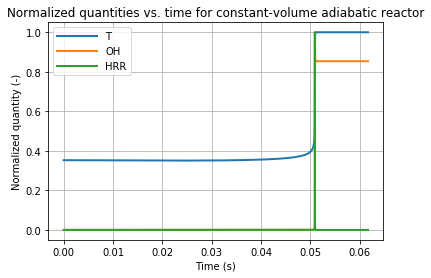

In [12]:
# plot the time evolution of temperature, OH, and heat-release rate
# scale each quantitity by its maximum value, so that it ranges from 0 to 1
Tmax   = max(timeHistory['temperature'])
OHmax  = max(timeHistory['OH'])
HRRmax = max(timeHistory['qdot'])

fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature']/Tmax, label='T',   lw=2)
ax.plot(timeHistory.index, timeHistory['OH']/OHmax,         label='OH',  lw=2)
ax.plot(timeHistory.index, timeHistory['qdot']/HRRmax,      label='HRR', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Normalized quantity (-)',
       title ='Normalized quantities vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst_PRF0.pdf")

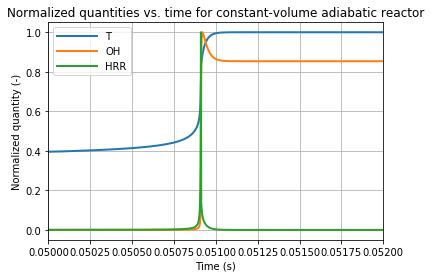

In [13]:
# zoom in around the time of ignition
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature']/Tmax, label='T',   lw=2)
ax.plot(timeHistory.index, timeHistory['OH']/OHmax,         label='OH',  lw=2)
ax.plot(timeHistory.index, timeHistory['qdot']/HRRmax,      label='HRR', lw=2)
ax.set(xlim=(0.050,0.052),
       xlabel='Time (s)',
       ylabel='Normalized quantity (-)',
       title ='Normalized quantities vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst_PRF0_zoomed.pdf")

The behavior is essentially the same as that seen in tutorial Notebook 6_1_Ignition_delay, with the exception of the longer ignition delay time here.

Now repeat the exercise for iso-octane fuel (PRF100):

In [14]:
# a stoichiometric mixture of iso-octane and air is considered next
T_0  = 1000.   # (K)
p_0  = 101325. # (Pa)
fuel = 'IC8H18'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# save the initial mixture composition (species mole fractions)
X_0 = gas.X

In [15]:
# define and name a constant-volume reactor that is filled with the ideal-gas mixture "gas"
reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume batch reactor")

# add "reactor" to a reactor network named "reactorNetwork"
reactorNetwork = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# append two more, beyond those that are used internally to characterize the reactor state
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# define an array to hold the heat-release rate at the current time t
# this is done for convenience in subsequent operations
# only array index 0 will actually be used
qdott = np.zeros(2)

# fill the first row of "timeHistory" with the initial condition
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

timeHistory

,mass,volume,temperature,H,H2,O,O2,OH,H2O,N2,...,C5H9OOH1-5,C5H9O1-5,C6H11OOH1-4,C6H11O1-4,C6H11OOH1-5,C6H11O1-5,C4H71-4,AR,qdot,empty
0.0,0.36879,1.0,1000.0,0.0,0.0,0.0,0.21847,0.0,0.0,0.719138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-151385.213495,0.0


In [16]:
# specify the integration end time in seconds
t_end   = 1.0

# perform the time integration using step()
ctim0 = time.time()

counter = 0
while t <= t_end:
    t = reactorNetwork.step()
    if not counter % 10:
        qdott[0]           = heat_release_rate()
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
    counter += 1

ctim1 = time.time()
ctime = ctim1 - ctim0

# the ignition delay time "tauOH" is the time at which OH mass fraction attains it maximum value
tauOH = ignitionDelay(timeHistory, 'OH')

# the ignition delay time "tauHRR" is the time at which the heat-release rate attains it maximum value
tauHRR = ignitionDelay(timeHistory, 'qdot')

# print the ignition delay times and computer time required
print('Ignition delay based on OH  is {:.3e} seconds.'.format(tauOH))
print('Ignition delay based on HRR is {:.3e} seconds.'.format(tauHRR))
print('This required {:3.2f} s to compute'.format(ctime))

Ignition delay based on OH  is 5.205e-02 seconds.
Ignition delay based on HRR is 5.204e-02 seconds.
This required 206.25 s to compute


For this initial condition, the ignition delay time for iso-octane is only a few percent longer than that for n-heptane. Larger differences between the two fuels will be seen in Section 3 below.

In [17]:
# save the time history to an Excel-compatible file for subsequent external post-processing
timeHistory.to_csv("time_history_PRF100.csv")

## 3. Ignition delay versus reactant temperature: NTC behavior

We next consider the constant-volume adiabatic combustion of stoichiometric n-heptane/air and iso-octane/air mixtures, initially at 1 atm, and over a range of initial temperatures. We will look at n-heptane (PRF0) first, then at iso-octane (PRF100).

In [18]:
# specify the initial pressure
p_0 = ct.one_atm

# specify the initial mixture composition
fuel = 'NC7H16'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

# specify the initial temperatures for which we will compute the ignition delays
T_0 = [1500., 1200., 1000., 900., 850., 825., 800.,
        750., 700., 675., 650., 600., 500.]

# specify the end times for the integration for each initial temperature
# here a constant value of 100.0 s is used for all cases
# even if the end time value is much longer than necessary, the computational time is not strongly affected,
#   since we use step() to perform the time integration, which will use a very long internal time step after ignition
EndTimes = 100.*np.ones(len(T_0))

In [19]:
# create another DataFrame to store the computed ignition delays for each initial temperature
ignitionDelays_PRF0 = pd.DataFrame(data={'T':T_0})
# initialize all ignition delay values to an undefined value ("nan" = not a number)
ignitionDelays_PRF0['ignDelay'] = np.nan

# print the initialized DataFrame
ignitionDelays_PRF0

,T,ignDelay
0,1500.0,NaN
1,1200.0,NaN
2,1000.0,NaN
3,900.0,NaN
4,850.0,NaN
5,825.0,NaN
6,800.0,NaN
7,750.0,NaN
8,700.0,NaN
9,675.0,NaN


Now compute the ignition delay for each initial temperature. To make this more self-contained, we repeat the definition of "gas" and the definitions of the functions that compute the heat-release rate and ignition-delay time.

Be patient when you run this cell. The calculation for each value of the initial temperature may take several minutes, depending on your computer.

In [20]:
# define the gas mixture
gas = ct.Solution('data/CurranEtAl_PRF_fromLLNL.cti')

# compute species formation enthalpies
Tref   = 298.15
gas.TP = Tref , None
hf     = gas.partial_molar_enthalpies

# define a function that returns the time at which a specified quantity in a DataFrame reaches its maximum value
def ignitionDelay(df, quantity):
    return df[quantity].idxmax()

# define a function that returns the heat-release rate in W/m^3
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

##### top of loop over initial temperatures #####
for i, temp in enumerate(T_0):
    
# initialize the gas thermochemical state and the reactor network
    gas.TP = temp, p_0
    gas.set_equivalence_ratio(phi,fuel,air)
    reactor = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
    reactorNetwork = ct.ReactorNet([reactor])

# create an empty data frame to store the time history for the current initial temperature
    timeHistory = pd.DataFrame(columns=timeHistory.columns)
    
# store the initial condition
    t = 0.
    qdott[0] = heat_release_rate()
    timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# initialize the timer
    ctim0 = time.time()

# perform the time integration for the current initial temperature
# save the reactor state once every 10 computational time steps
    counter = 0
    while t < EndTimes[i]:
        t = reactorNetwork.step()
        if not counter % 10:
            qdott[0] = heat_release_rate()
            timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
        counter += 1

# compute the elapsed computer time for the current initial temperature
    ctim1 = time.time()
    ctime = ctim1 - ctim0
    
# compute the ignition delay time based on heat-release rate for the current initial temperature
    tau = ignitionDelay(timeHistory, 'qdot')

# print the initial temperature, ignition delay time, and compute time required for the current initial temperature
    print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(temp, tau, ctime))

# store the computed ignition delays in a DataFrame
    ignitionDelays_PRF0.at[i,'ignDelay'] = tau
    
##### end of loop over initial temperatures #####
    
# print the computed ignition delay times
ignitionDelays_PRF0



**** WARNING ****
For species TC3H6CHO, discontinuity in h/RT detected at Tmid = 1389
	Value computed using low-temperature polynomial:  12.1489
	Value computed using high-temperature polynomial: 12.1062


**** WARNING ****
For species C7H15O-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767
Initial T = 1500.00 K, ignition delay (HRR) = 5.647e-05 s, compute time = 1.624e+02 s
Initial T = 1200.00 K, ignition delay (HRR) = 2.107e-03 s, compute time = 1.699e+02 s
Initial T = 1000.00 K, ignition delay (HRR) = 5.091e-02 s, compute time = 2.065e+02 s
Initial T = 900.00 K, ignition delay (HRR) = 2.633e-01 s, compute time = 2.192e+02 s
Initial T = 850.00 K, ignition delay (HRR) = 5.399e-01 s, compute time = 2.220e+02 s
Initial T = 825.00 K, ignition delay (HRR) = 6.232e-01 s, compute time = 2.372e+02 s
Initial T = 800.00 K, ignition delay (HRR) = 5.467e-01 s, compute time = 2.3

,T,ignDelay
0,1500.0,0.000056
1,1200.0,0.002107
2,1000.0,0.050911
3,900.0,0.263297
4,850.0,0.539853
5,825.0,0.623235
6,800.0,0.546688
7,750.0,0.264092
8,700.0,0.108716
9,675.0,0.082922


As noted earlier, the computational time generally increases with decreasing initial temperature.

Now plot the computed ignition delay time as a function of initial temperature. As in tutorial Notebook 6_1_Ignition_delay, the x axis is taken to be linear in the inverse of the temperature, and a logarithmic scale is used for ignition-delay time on the y axis. This is the conventional way in which the temperature variation of ignition-delay time is often plotted. 

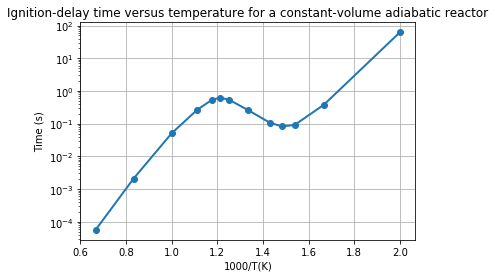

In [21]:
# plot ignition delay versus initial temperature
fig, ax = plt.subplots()
ax.semilogy(1000./ignitionDelays_PRF0['T'], ignitionDelays_PRF0['ignDelay'], lw=2, marker='o')
ax.set(xlabel='1000/T(K)',
       ylabel='Time (s)',
       title ='Ignition-delay time versus temperature for a constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("igndelay_vs_T_vconst_PRF0.pdf")

The results are similar to those obtained using a reduced reaction mechanism in tutorial Notebook 6_1_Ignition_delay, although the ignition delay times here are generally higher. As discussed there, *negative temperature coefficient* (NTC) behavior is observed over a range of initial temperatures between approximately 675 and 825 K. 

Now repeat the calculations for iso-octane (PRF100):

In [22]:
# specify the initial pressure
p_0 = ct.one_atm

# specify the initial mixture composition
fuel = 'IC8H18'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

# specify the initial temperatures for which we will compute the ignition delays
T_0 = [ 1300., 1000., 800., 725., 700., 675., 650., 625., 600., 575., 525.]

# specify the end times for the integration for each initial temperature
# here a constant value of 100.0 s is used for all cases
# even if the end time value is much longer than necessary, the computational time is not strongly affected,
#   since we use step() to perform the time integration, which will use a very long internal time step after ignition
EndTimes = 100.*np.ones(len(T_0))

In [23]:
# create another DataFrame to store the computed ignition delays for each initial temperature
ignitionDelays_PRF100 = pd.DataFrame(data={'T':T_0})
# initialize all ignition delay values to an undefined value ("nan" = not a number)
ignitionDelays_PRF100['ignDelay'] = np.nan

# print the initialized DataFrame
ignitionDelays_PRF100

,T,ignDelay
0,1300.0,NaN
1,1000.0,NaN
2,800.0,NaN
3,725.0,NaN
4,700.0,NaN
5,675.0,NaN
6,650.0,NaN
7,625.0,NaN
8,600.0,NaN
9,575.0,NaN


In [24]:
# define the gas mixture
gas = ct.Solution('data/CurranEtAl_PRF_fromLLNL.cti')

# compute species formation enthalpies
Tref   = 298.15
gas.TP = Tref , None
hf     = gas.partial_molar_enthalpies

# define a function that returns the time at which a specified quantity in a DataFrame reaches its maximum value
def ignitionDelay(df, quantity):
    return df[quantity].idxmax()

# define a function that returns the heat-release rate in W/m^3
def heat_release_rate():
    qdot = 0.
    for i in range(gas.n_species):
        qdot += -gas.net_production_rates[i]*hf[i]
    return qdot

##### top of loop over initial temperatures #####
for i, temp in enumerate(T_0):
    
# initialize the gas thermochemical state and the reactor network
    gas.TP = temp, p_0
    gas.set_equivalence_ratio(phi,fuel,air)
    reactor = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
    reactorNetwork = ct.ReactorNet([reactor])

# create an empty data frame to store the time history for the current initial temperature
    timeHistory = pd.DataFrame(columns=timeHistory.columns)
    
# store the initial condition
    t = 0.
    qdott[0] = heat_release_rate()
    timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# initialize the timer
    ctim0 = time.time()

# perform the time integration for the current initial temperature
# save the reactor state once every 10 computational time steps
    counter = 0
    while t < EndTimes[i]:
        t = reactorNetwork.step()
        if not counter % 10:
            qdott[0] = heat_release_rate()
            timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
        counter += 1

# compute the elapsed computer time for the current initial temperature
    ctim1 = time.time()
    ctime = ctim1 - ctim0
    
# compute the ignition delay time based on heat-release rate for the current initial temperature
    tau = ignitionDelay(timeHistory, 'qdot')

# print the initial temperature, ignition delay time, and compute time required for the current initial temperature
    print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(temp, tau, ctime))

# store the computed ignition delays in a DataFrame
    ignitionDelays_PRF100.at[i,'ignDelay'] = tau
    
##### end of loop over initial temperatures #####
    
# print the computed ignition delay times
ignitionDelays_PRF100



**** WARNING ****
For species TC3H6CHO, discontinuity in h/RT detected at Tmid = 1389
	Value computed using low-temperature polynomial:  12.1489
	Value computed using high-temperature polynomial: 12.1062


**** WARNING ****
For species C7H15O-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767
Initial T = 1300.00 K, ignition delay (HRR) = 9.929e-04 s, compute time = 1.726e+02 s
Initial T = 1000.00 K, ignition delay (HRR) = 5.204e-02 s, compute time = 2.012e+02 s
Initial T = 800.00 K, ignition delay (HRR) = 2.087e+00 s, compute time = 2.377e+02 s
Initial T = 725.00 K, ignition delay (HRR) = 1.446e+01 s, compute time = 2.727e+02 s
Initial T = 700.00 K, ignition delay (HRR) = 1.872e+01 s, compute time = 2.822e+02 s
Initial T = 675.00 K, ignition delay (HRR) = 1.410e+01 s, compute time = 3.080e+02 s
Initial T = 650.00 K, ignition delay (HRR) = 6.752e+00 s, compute time = 3.24

,T,ignDelay
0,1300.0,0.000993
1,1000.0,0.052045
2,800.0,2.087374
3,725.0,14.457846
4,700.0,18.719666
5,675.0,14.095283
6,650.0,6.752496
7,625.0,4.385200
8,600.0,4.131377
9,575.0,6.976770


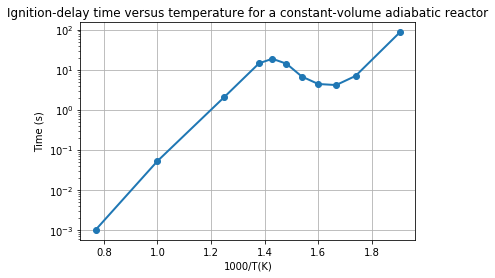

In [25]:
# plot ignition delay versus initial temperature
fig, ax = plt.subplots()
ax.semilogy(1000./ignitionDelays_PRF100['T'], ignitionDelays_PRF100['ignDelay'], lw=2, marker='o')
ax.set(xlabel='1000/T(K)',
       ylabel='Time (s)',
       title ='Ignition-delay time versus temperature for a constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("igndelay_vs_T_vconst_PRF100.pdf")

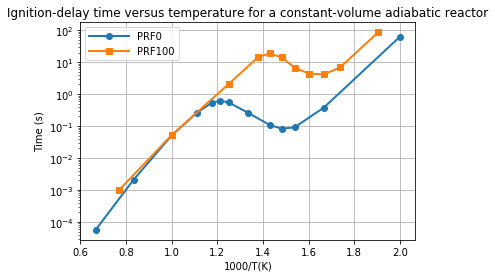

In [26]:
# plot ignition delay versus initial temperature for two fuels
fig, ax = plt.subplots()
ax.semilogy(1000./ignitionDelays_PRF0['T'],   ignitionDelays_PRF0['ignDelay'],   lw=2, marker='o', label='PRF0'  )
ax.semilogy(1000./ignitionDelays_PRF100['T'], ignitionDelays_PRF100['ignDelay'], lw=2, marker='s', label='PRF100')
ax.set(xlabel='1000/T(K)',
       ylabel='Time (s)',
       title ='Ignition-delay time versus temperature for a constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("igndelay_vs_T_vconst_PRFs.pdf")

## 4. Two-stage heat release

As discussed in tutorial Notebook 6_1_Ignition delay, two-state heat release can occur for some reactant mixtures under some conditions. For n-heptane, for example:

In [27]:
# initialize the gas mixture to a temperature at which NTC behavior is observed
T_0  = 750.
p_0  = ct.one_atm
fuel = 'NC7H16'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# initialize the reactor, reacto network, and Pandas DataFrame
reactor            = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
reactorNetwork     = ct.ReactorNet([reactor])
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')
timeHistory       = pd.DataFrame(columns=stateVariableNames)

qdott    = np.zeros(2)
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# perform the time integration
ctim0 = time.time()
t_end   = 10.0
counter = 0
while t <= t_end:
    t = reactorNetwork.step()
    if not counter % 10:
        qdott[0]           = heat_release_rate()
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
    counter += 1

ctim1 = time.time()
ctime = ctim1 - ctim0
    
# compute the ignition-delay time
tau = ignitionDelay(timeHistory, 'qdot')

print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(T_0, tau, ctime))

Initial T = 750.00 K, ignition delay (HRR) = 2.641e-01 s, compute time = 2.839e+02 s


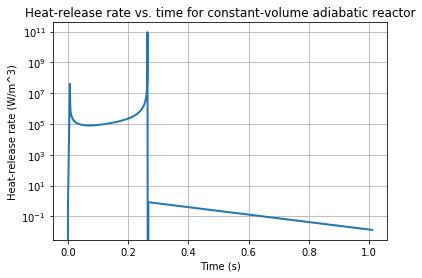

In [28]:
# plot the heat-release rate as a function of time, using a logarithmic scale for the heat-release rate
#   so that the two-peak structure is evident
fig, ax = plt.subplots()
ax.semilogy(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
#ax.plot(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Heat-release rate (W/m^3)',
       title ='Heat-release rate vs. time for constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("HRR_vs_t_vconst_PRF0.pdf")

Repeat the calculation for iso-octane fuel at a temperature at which it exhibits NTC behavior:

In [29]:
# initialize the gas mixture to a temperature at which NTC behavior is observed
T_0  = 650.
p_0  = ct.one_atm
fuel = 'IC8H18'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# initialize the reactor, reacto network, and Pandas DataFrame
reactor            = ct.IdealGasReactor(contents=gas, name='Constant-volume batch reactor')
reactorNetwork     = ct.ReactorNet([reactor])
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('qdot')
stateVariableNames.append('empty')
timeHistory       = pd.DataFrame(columns=stateVariableNames)

qdott    = np.zeros(2)
t        = 0.
qdott[0] = heat_release_rate()
timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))

# perform the time integration
ctim0 = time.time()
t_end   = 10.0
counter = 0
while t <= t_end:
    t = reactorNetwork.step()
    if not counter % 10:
        qdott[0]           = heat_release_rate()
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),qdott))
    counter += 1

ctim1 = time.time()
ctime = ctim1 - ctim0
    
# compute the ignition-delay time
tau = ignitionDelay(timeHistory, 'qdot')

print('Initial T = {:3.2f} K, ignition delay (HRR) = {:.3e} s, compute time = {:.3e} s'.format(T_0, tau, ctime))

Initial T = 650.00 K, ignition delay (HRR) = 6.752e+00 s, compute time = 3.267e+02 s


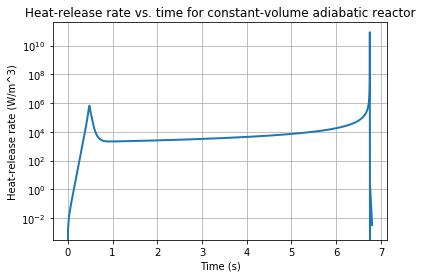

In [18]:
# plot the heat-release rate as a function of time, using a logarithmic scale for the heat-release rate
#   so that the two-peak structure is evident
fig, ax = plt.subplots()
ax.semilogy(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
#ax.plot(timeHistory.index, timeHistory['qdot'], label='HRR', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Heat-release rate (W/m^3)',
       title ='Heat-release rate vs. time for constant-volume adiabatic reactor')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("HRR_vs_t_vconst_PRF100.pdf")

So, both fuels exhibit two-stage ignition in their respective NTC-behavior regions.

The code can be exercised further to explore the ranges of pressure, temperature, and equivalence ratio over which NTC and/or multiple-stage heat release manifest for various n-heptane/iso-octane fuel blends between PRF0 and PRF100.